# UMAP chess dataset EDA

---

**SECTIONS:**

[1. Staging](#1.-Staging) \
----[1.1 Project parametrisation](#1.1-Project-parametrisation) \
----[1.2 Functions](#1.2-Functions)

[2. Data preprocessing & initial dataset exploration](#2.-Data-preprocessing-&-initial-dataset-exploration) 

[3. Dataset vectorisation](#3.-Dataset-vectorisation)

[4. Data exploration with UMAP](#4.-Data-exploration-with-UMAP)

## 1. Staging

---

import section:

In [332]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import umap

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

import tqdm.notebook as tqn
import pdb

In [333]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

plt.rcParams['figure.dpi'] = 300

### 1.1 Project parametrisation

1. General parameters
2. Vectorized moves table
3. Metadata table

#### 1.1.1 General parameters

In [334]:
## project
notebook_ver = 0.4
## input dataset
data_pth = './data/games.csv'

## Qualitative palette 4 cats
qual_cmap = ['#d7191c','#fdae61','#abd9e9','#2c7bb6']

#### 1.1.2 Vectorized moves table parameters

#### 1.1.3 Metadata table params

In [335]:
## Define nominal data variables to be thrown at one-hot-encoder
to_hot_encode = [
    'opening_eco',
    'increment_code',
    'victory_status'
]

## Define string variables for str vectorization
to_vectorize = [
    'white_id',
    'black_id'
]

## Define numerical cols to use
num_cols = [
    'winner_bin',
    'rated_bin',
    'game_len_mins',
#     'turns', # dense var
#     'white_rating', # dense var
#     'black_rating', # dense var
    'opening_ply'
]

### 1.2 Functions

In [336]:
def to_uni(mov):
    '''
    Turn str move encoding into a sequence of Unicode values
    '''
    move_unicode = []
    for char in str(mov):
        move_unicode.append(ord(char))
    return move_unicode

In [337]:
def encode_moves(moves_seq, encoding='unilog', magnitude=10_000_000):
    '''
    Encode move into an integer = 1*e^10
    '''
    moves = []

    for move in moves_seq.split(' '):
        ## Convert str encoding to unicode vals
        move_uni = to_uni(move)
        ## Multiply all unicode vals together
        move_prod = np.prod(np.array(move_uni))  
        
        if encoding == 'unilog':
            ## Take log2 for every move and multiply by 10_000_000
            moves.append(int(np.log2(move_prod)*magnitude))
        elif encoding == 'unicode':
            moves.append(int(move_prod))
        
    return(moves)

In [338]:
def move_vectorizer(moves_df, id_col='id'):
    """
    Takes long moves table and transposes it to wide format
    :return: list of pd.DataFrames 
    """
    
    transposed_moves = []
    
    ## Setup a tqn loop 
    for game in tqn.trange(0, len(moves_df.index.unique())):
        ## Slice source by game idx 
        GRABBED_MOVES = moves_df.loc[game] 
        ## Each column will correspond to a move number in the game sequence
        cols = range(1,len(GRABBED_MOVES)+1)
        
        ## Some games have only one move in that case pd.Series returns a single 'str' val
        ## instead of a list of strings. 
        if type(GRABBED_MOVES[id_col]) is str:
            game_id = GRABBED_MOVES[id_col]
            GRABBED_MOVES_TR = GRABBED_MOVES.iloc[0]
            ## Construct dataframe that represent game moves in a vector
            TRANS_MOVES = pd.DataFrame({1:GRABBED_MOVES_TR}, index=[game_id])
        else:
            game_id = GRABBED_MOVES[id_col].unique()[0]
            GRABBED_MOVES_TR = GRABBED_MOVES.drop(columns=id_col)
            ## Construct dataframe that represent game moves in a vector
            TRANS_MOVES = pd.DataFrame(GRABBED_MOVES_TR).T
            TRANS_MOVES.index = [game_id]
            TRANS_MOVES.columns = cols
        
        transposed_moves.append(TRANS_MOVES)
        
    return transposed_moves

In [405]:
def umap_transformer(data_,
                    dist_metric,
                    nn,
                    min_dist):
    """
    Ultra robust function to transform vectors with UMAP model
    :data_: pd.dataframe, vectorised data
    :dist_metric: str, distance metric, choose from:
        * euclidean
        * manhattan
        * chebyshev
        * minkowski
        * canberra
        * braycurtis
        * mahalanobis
        * wminkowski
        * seuclidean
        * cosine
        * correlation
        * haversine
        * hamming
        * jaccard
        * dice
        * russelrao
        * kulsinski
        * ll_dirichlet
        * hellinger
        * rogerstanimoto
        * sokalmichener
        * sokalsneath
        * yule
    :nn: int, nearest neighbors
    :min_dist: float, minimal distance between neighbors
    :return: pd.DataFrame, embedded data
    """
    
    ## Instantiate UMAP model
    reducer = umap.UMAP(metric=dist_metric,
                       n_neighbors=nn,
                       min_dist=min_dist)
    
    ## Train the model
    embedding = reducer.fit_transform(data_)
    
    ## Post-process embedded data
    EMBEDDING_DF = pd.DataFrame(embedding, columns=['x','y'])
    EMBEDDING_DF = EMBEDDING_DF.fillna(0)
    
    return EMBEDDING_DF

In [452]:
def plot_umap(data_, 
              m_shape, 
              m_size, 
              c_map_var, 
              c_map, 
              alpha, 
              dist_metric, 
              nn, 
              min_dist, 
              title, 
              dpi, 
              labels=False, 
              save=False, 
              show=True):
    """
    Ultra robust function for UMAP plotting.
    
    :m_shape: str, marker shape
    :m_size: int, marker size
    :c_map_var: sequence, color map variable
    :c_map: str, color map
    :alpha: float
    :dist_metric: str, distance metric
    :nn: int, number of nearest neighbors for local graph
    :min_dist: float, minimum distance between neighbors
    :title: str, plot title
    :dpi: int
    :labels: bool
    :save: bool
    :show: bool
    """
    
    ## Figure params
    fig = plt.figure(figsize=(14,12))
    fig.patch.set_facecolor('black')
    
#     sns.scatterplot(data=GAMES,
#                 x='turns',
#                 y='game_len_mins',
#                 hue='victory_status',
#                 palette=qual_cmap,
#                 size='rating_distance',
#                 sizes=(20,400),
#                 edgecolor=None,
#                 s=10,
#                 alpha=0.4,
#                 legend=True)
    
    ## Define scatter plot params
    sns.scatterplot(data=data_,
        x=data_['x'], 
                y=data_['y'], 
                size=c_map_var,
                sizes={k:(5 if k<300 else 250) for k in c_map_var},
                markers=m_shape,
                s=m_size,
                edgecolor=None,
                hue=c_map_var,
                palette=c_map, 
                alpha=alpha,
                legend=labels)
    
    ## General plot params
    plt.axis("off")

    ## Color-bar and title parameters
    if labels:
        c_bar = plt.colorbar(fraction=0.05, 
                            shrink=0.5,
                            ticks=[cmap_var.min(), 
                                np.quantile(cmap_var,0.50),
                                np.quantile(cmap_var,0.75),
                                cmap_var.max()], 
                             alpha=alpha
                               )

        c_bar.set_label(cmap_var.name, 
                        color='white')
        c_bar.ax.yaxis.set_tick_params(color='white')
        c_bar.solids.set_edgecolor("face")

        plt.setp(plt.getp(c_bar.ax.axes, 'yticklabels'), 
                 color='white')
        
        plt.title(f'{title}\n20k chess games; distance={dist_metric}; nn={nn}, min_dist={min_dist}', 
                  color='w')
    
    ## plot save params
    if save:
        plt.savefig(f"screens/{dist_metric}_nn{nn}_mind{min_dist}_v{notebook_ver}.png", 
                    dpi=dpi, 
                    facecolor='black')
    
    if show:
        plt.show()

### 1.3 Data load 

In [339]:
GAMES = pd.read_csv(data_pth)

## 2. Data preprocessing & initial dataset exploration

---

### 2.1 Preprocessing

In [340]:
## Encode binary variables to integers
GAMES['rated_bin'] = np.where(GAMES['rated'] == True, 1, 0)

GAMES.drop(columns='rated',
          inplace=True)

In [341]:
GAMES['winner_bin'] = np.where(GAMES['winner'] == 'white', 0, 1)

GAMES.drop(columns='winner',
          inplace=True)

In [342]:
## Opening, closing games dates transformation
GAMES['created_at_dt'] = pd.to_datetime(GAMES['created_at']/1000, unit='s', origin='unix')
GAMES['last_move_at_dt'] = pd.to_datetime(GAMES['last_move_at']/1000, unit='s', origin='unix')

GAMES['game_len_dt'] = GAMES['last_move_at_dt'] - GAMES['created_at_dt']
GAMES['game_len'] = GAMES['last_move_at'] - GAMES['created_at']

In [343]:
GAMES['game_len_mins'] = GAMES['game_len'].apply(lambda x: int(x/1000/60))

In [344]:
## Convert categorical labels to numeric
GAMES['victory_status_factorized'] = pd.factorize(GAMES['victory_status'])[0]

In [ ]:
## Construct rating distance var
GAMES['rating_distance'] = GAMES['white_rating'] - GAMES['black_rating']
GAMES['rating_distance'] = GAMES['rating_distance'].apply(abs)

### 2.2 Data exploration

In [345]:
GAMES['rating_distance'].describe()

count    20058.000000
mean       173.091435
std        179.214854
min          0.000000
25%         45.000000
50%        115.000000
75%        241.000000
max       1605.000000
Name: rating_distance, dtype: float64

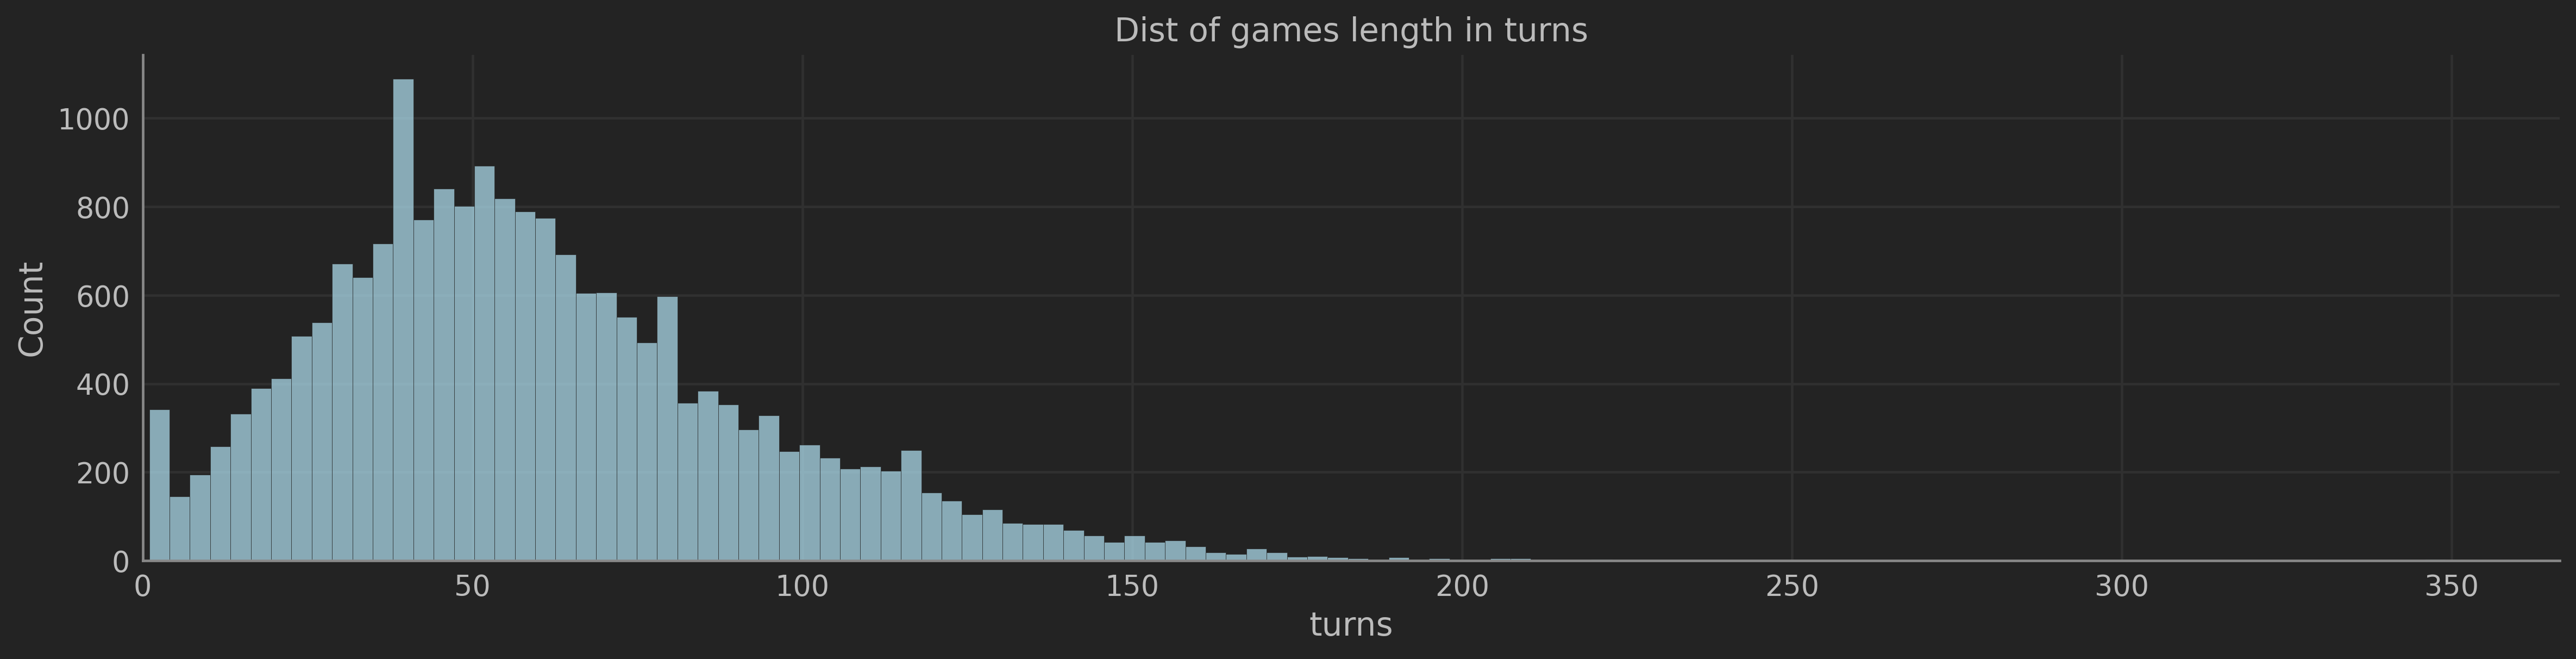

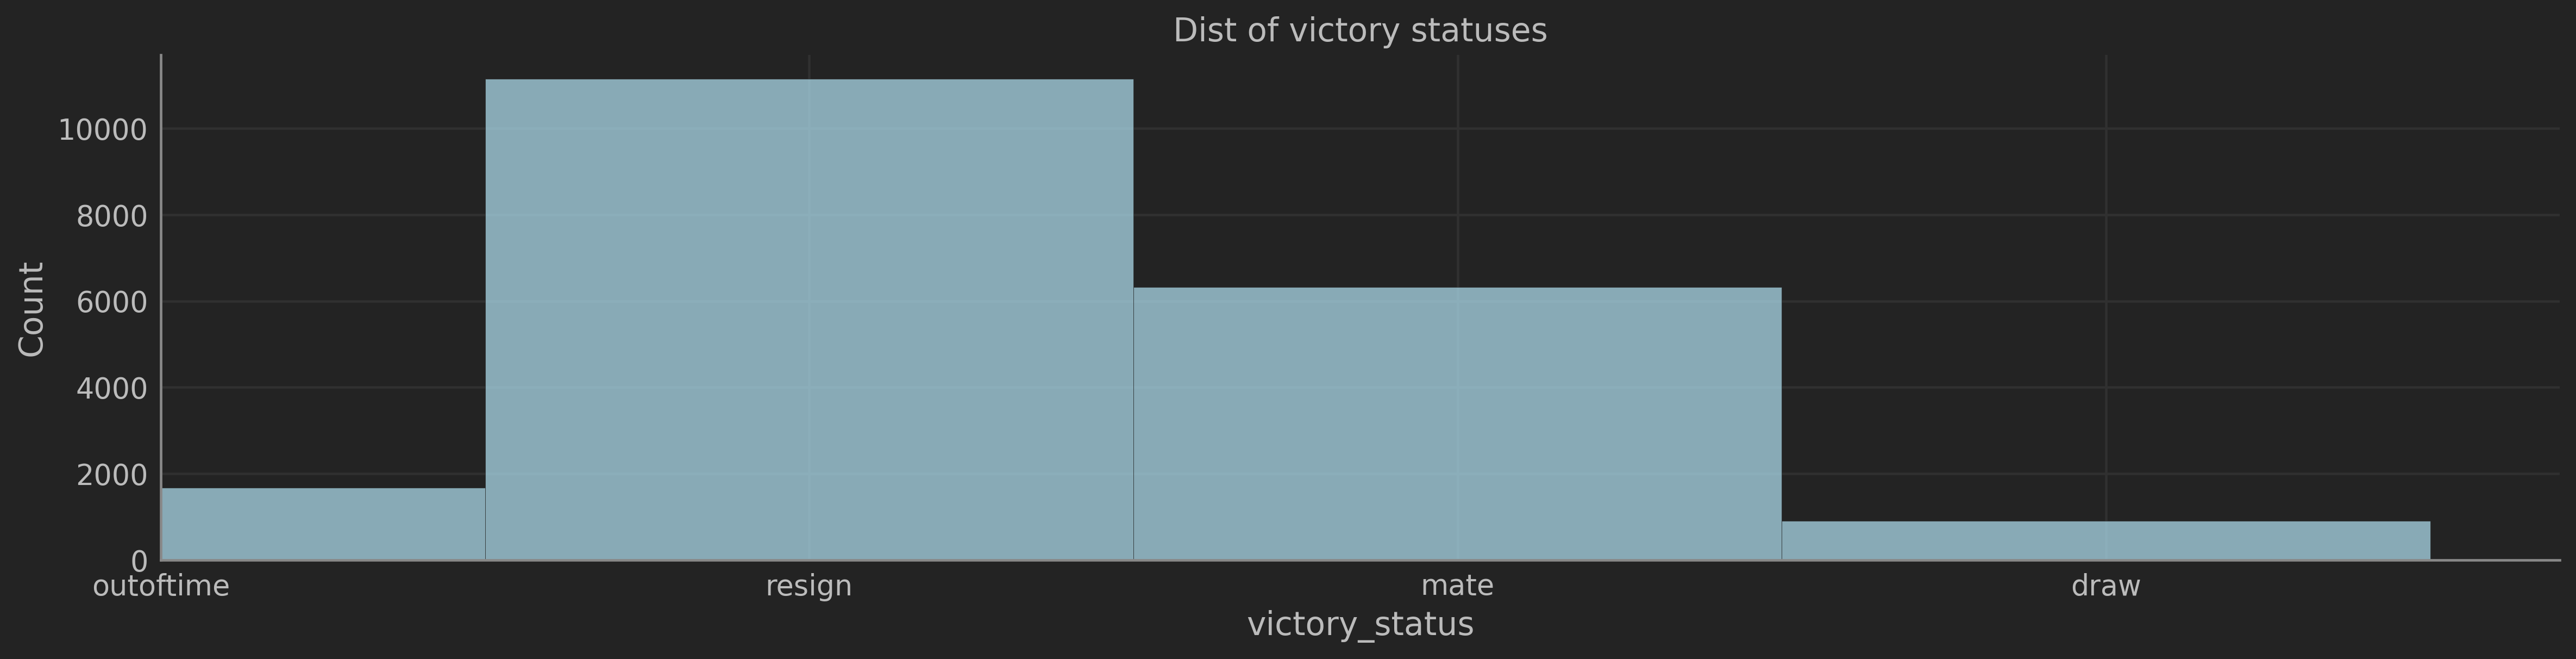

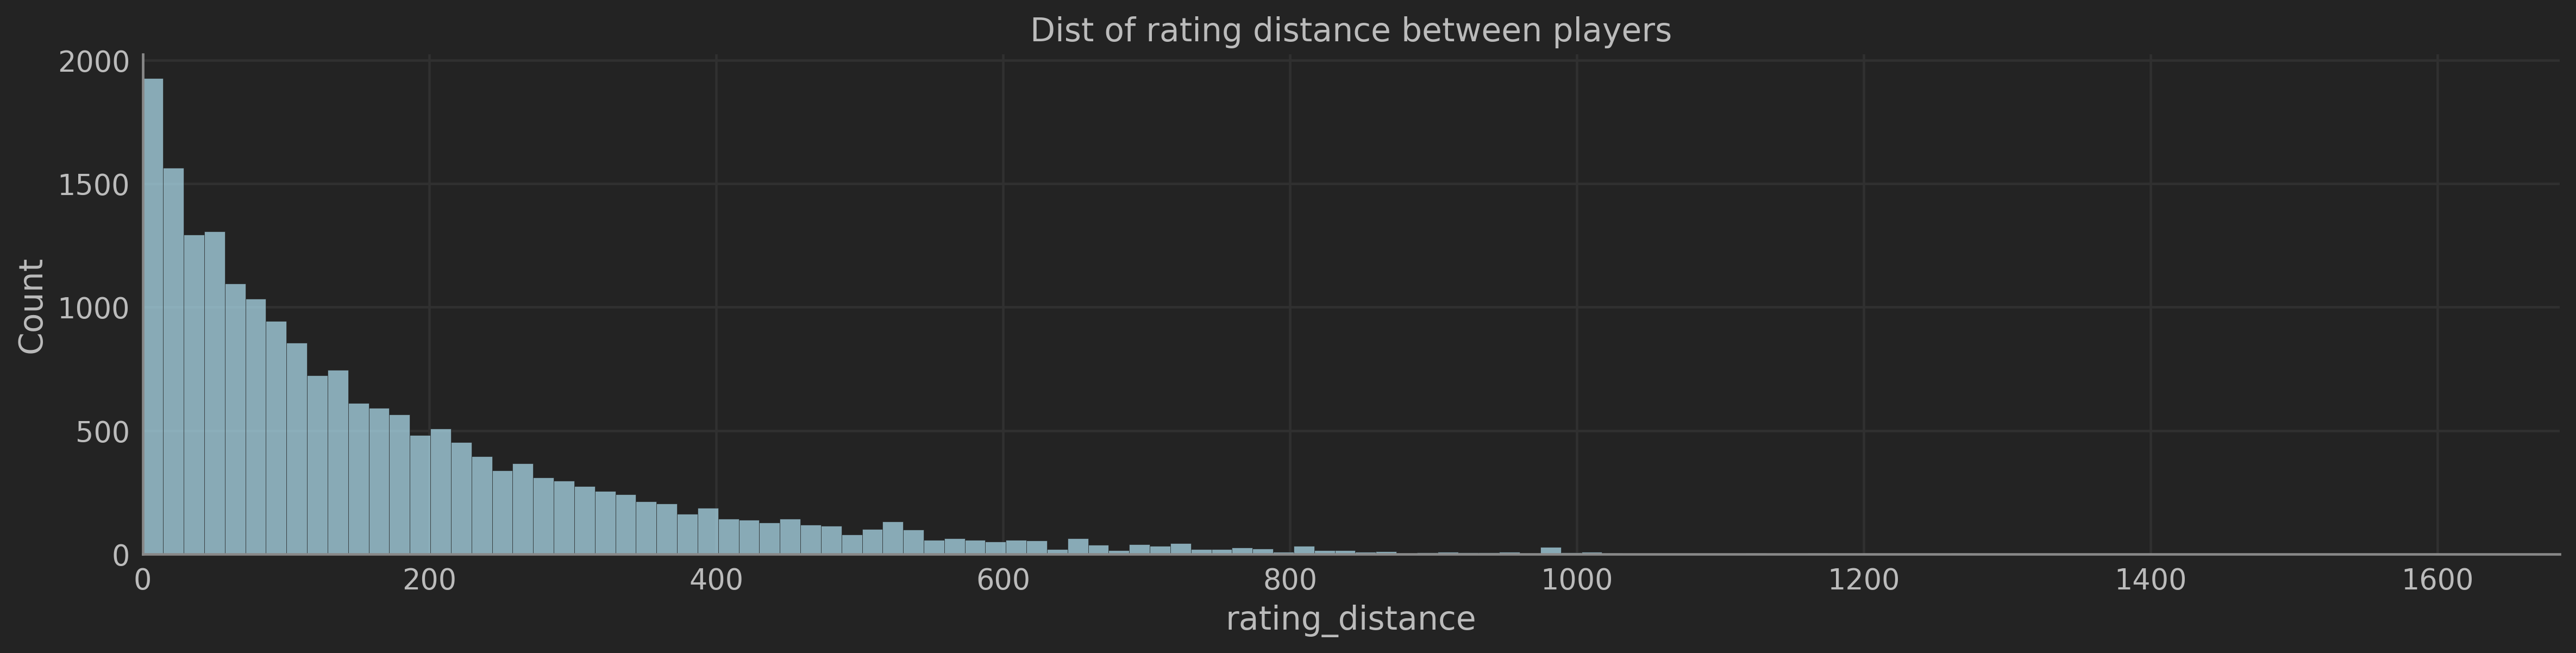

In [346]:
to_plot = [
    ('turns', 'Dist of games length in turns'),
    ('victory_status', 'Dist of victory statuses'),
    ('rating_distance', 'Dist of rating distance between players')
]

for var, title in to_plot:
    sns.displot(GAMES[var],
            color=qual_cmap[-2],
            height=4, 
            aspect=4)
    
    plt.title(title)
    plt.xlim((0))
    plt.ylim((0))
    plt.show()

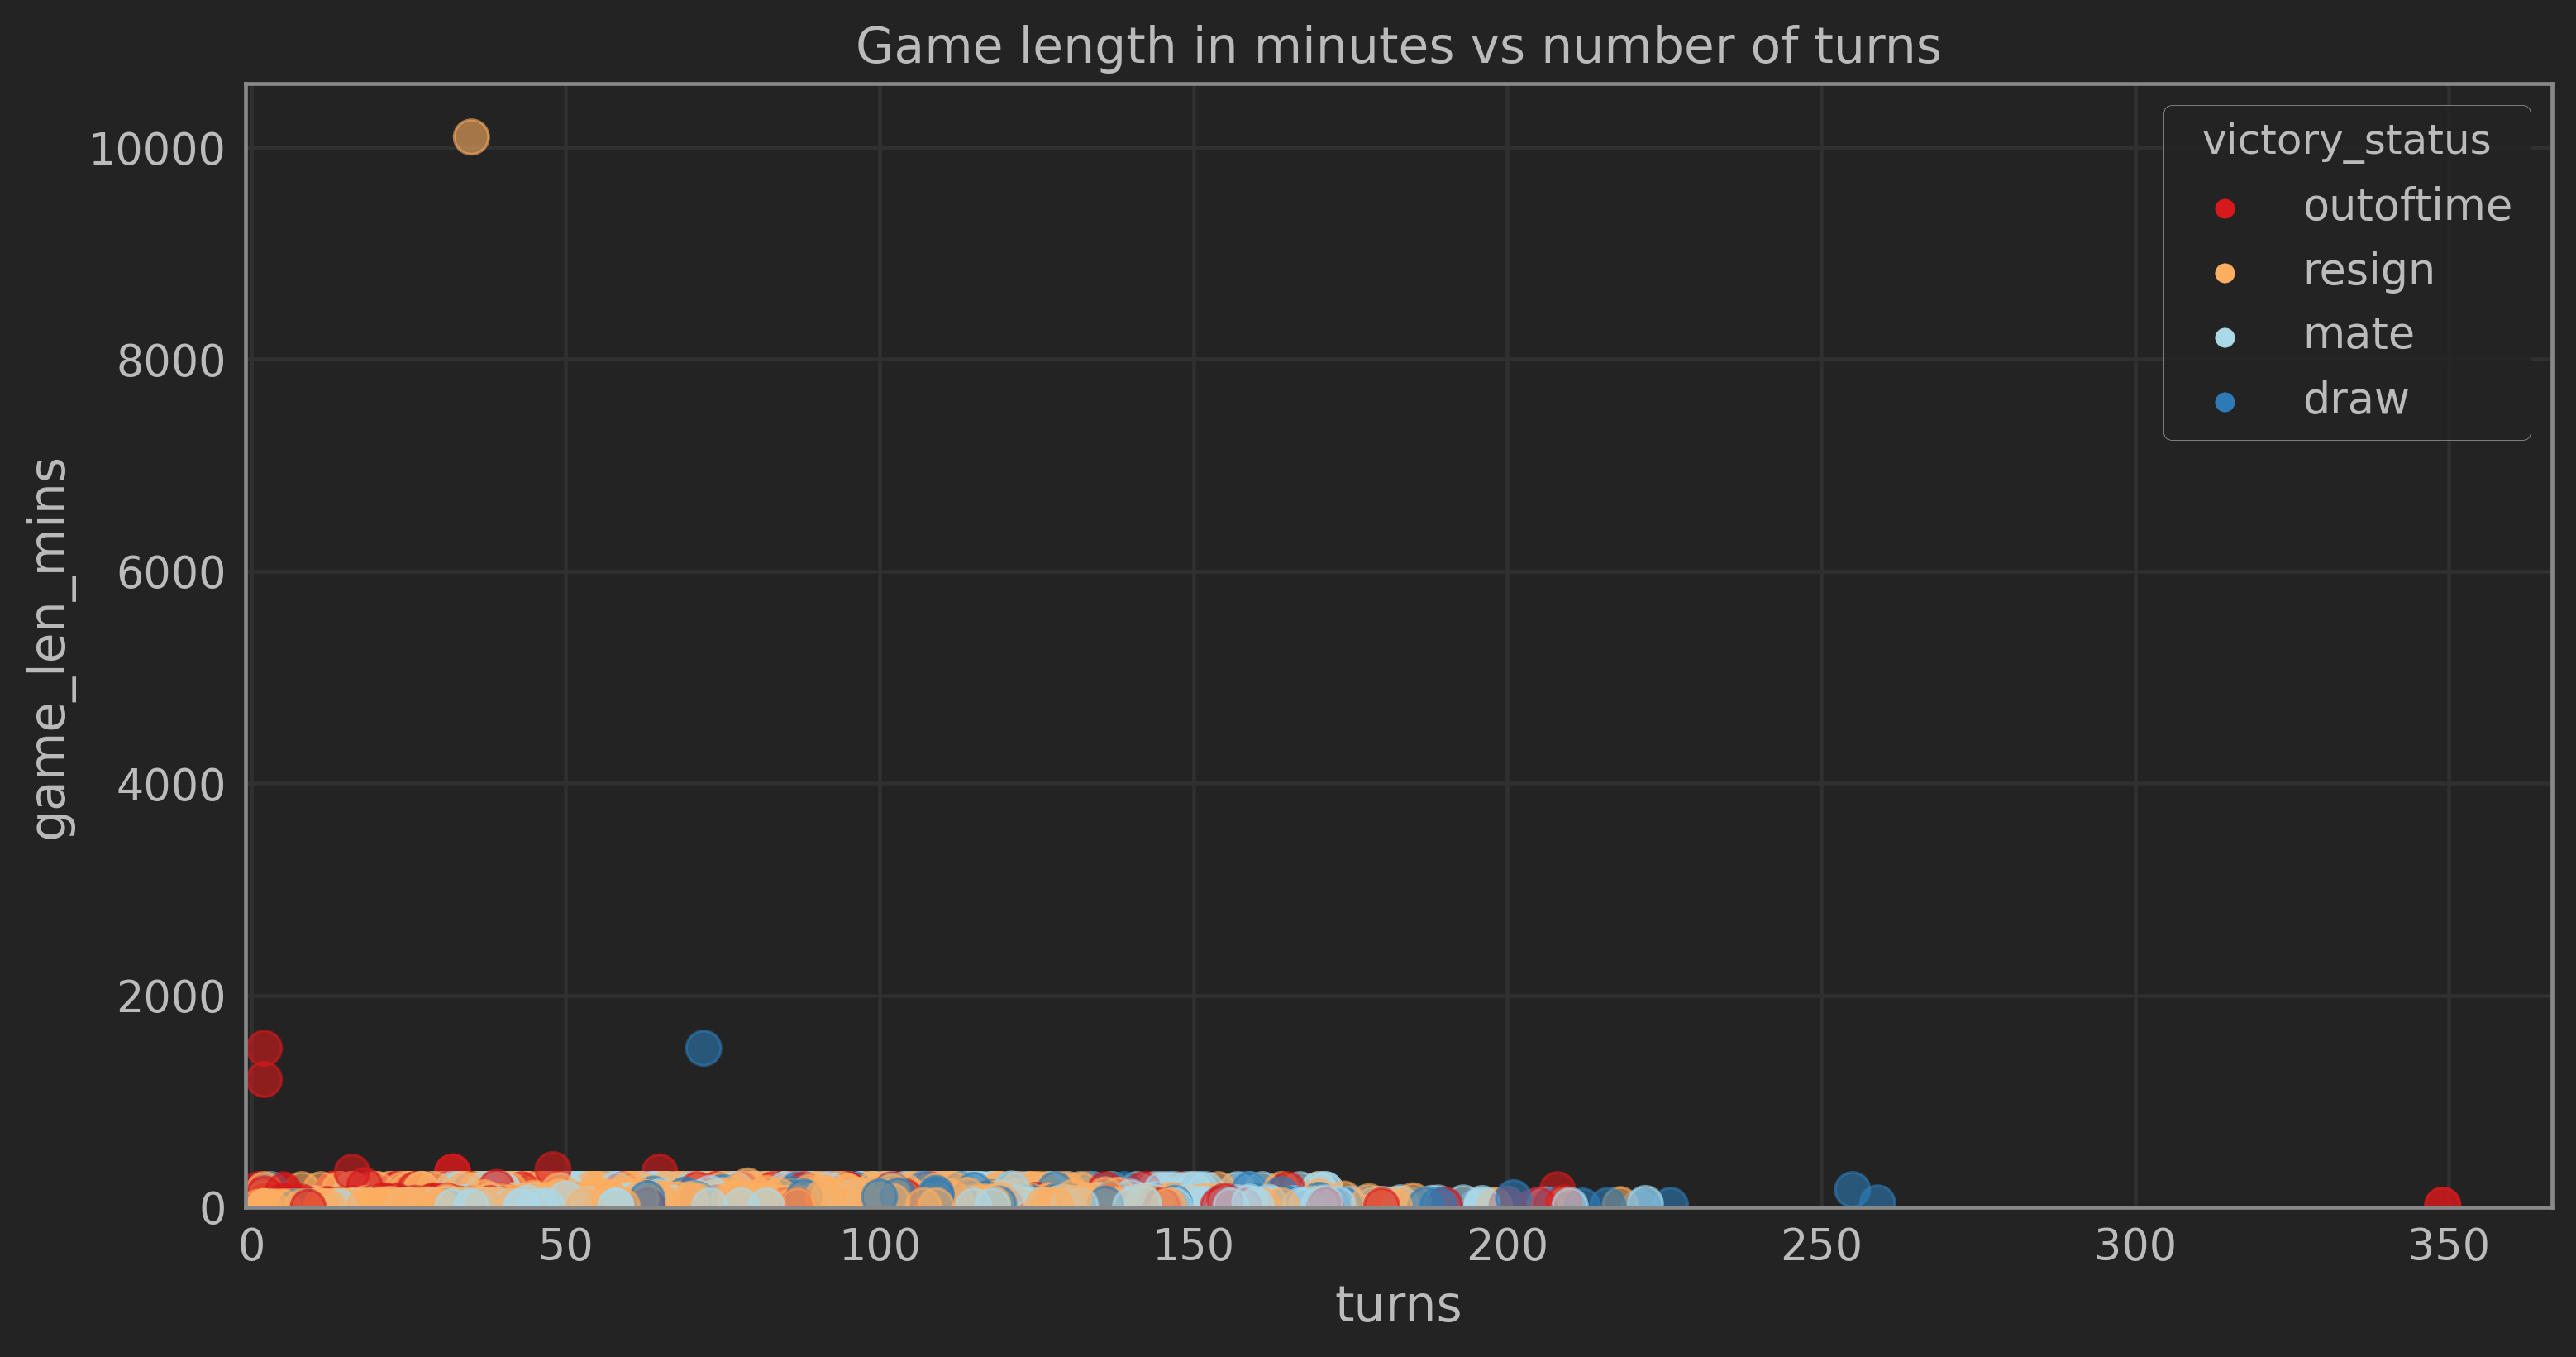

In [347]:
plt.figure(figsize=(12,6))

sns.scatterplot(data=GAMES,
                x='turns',
                y='game_len_mins',
                s=100,
                hue='victory_status',
                palette=qual_cmap,
                edgecolor=None,
                alpha=0.6,
                legend=True)

plt.title('Game length in minutes vs number of turns')
plt.xlim((-1))
plt.ylim((-1))
plt.show()

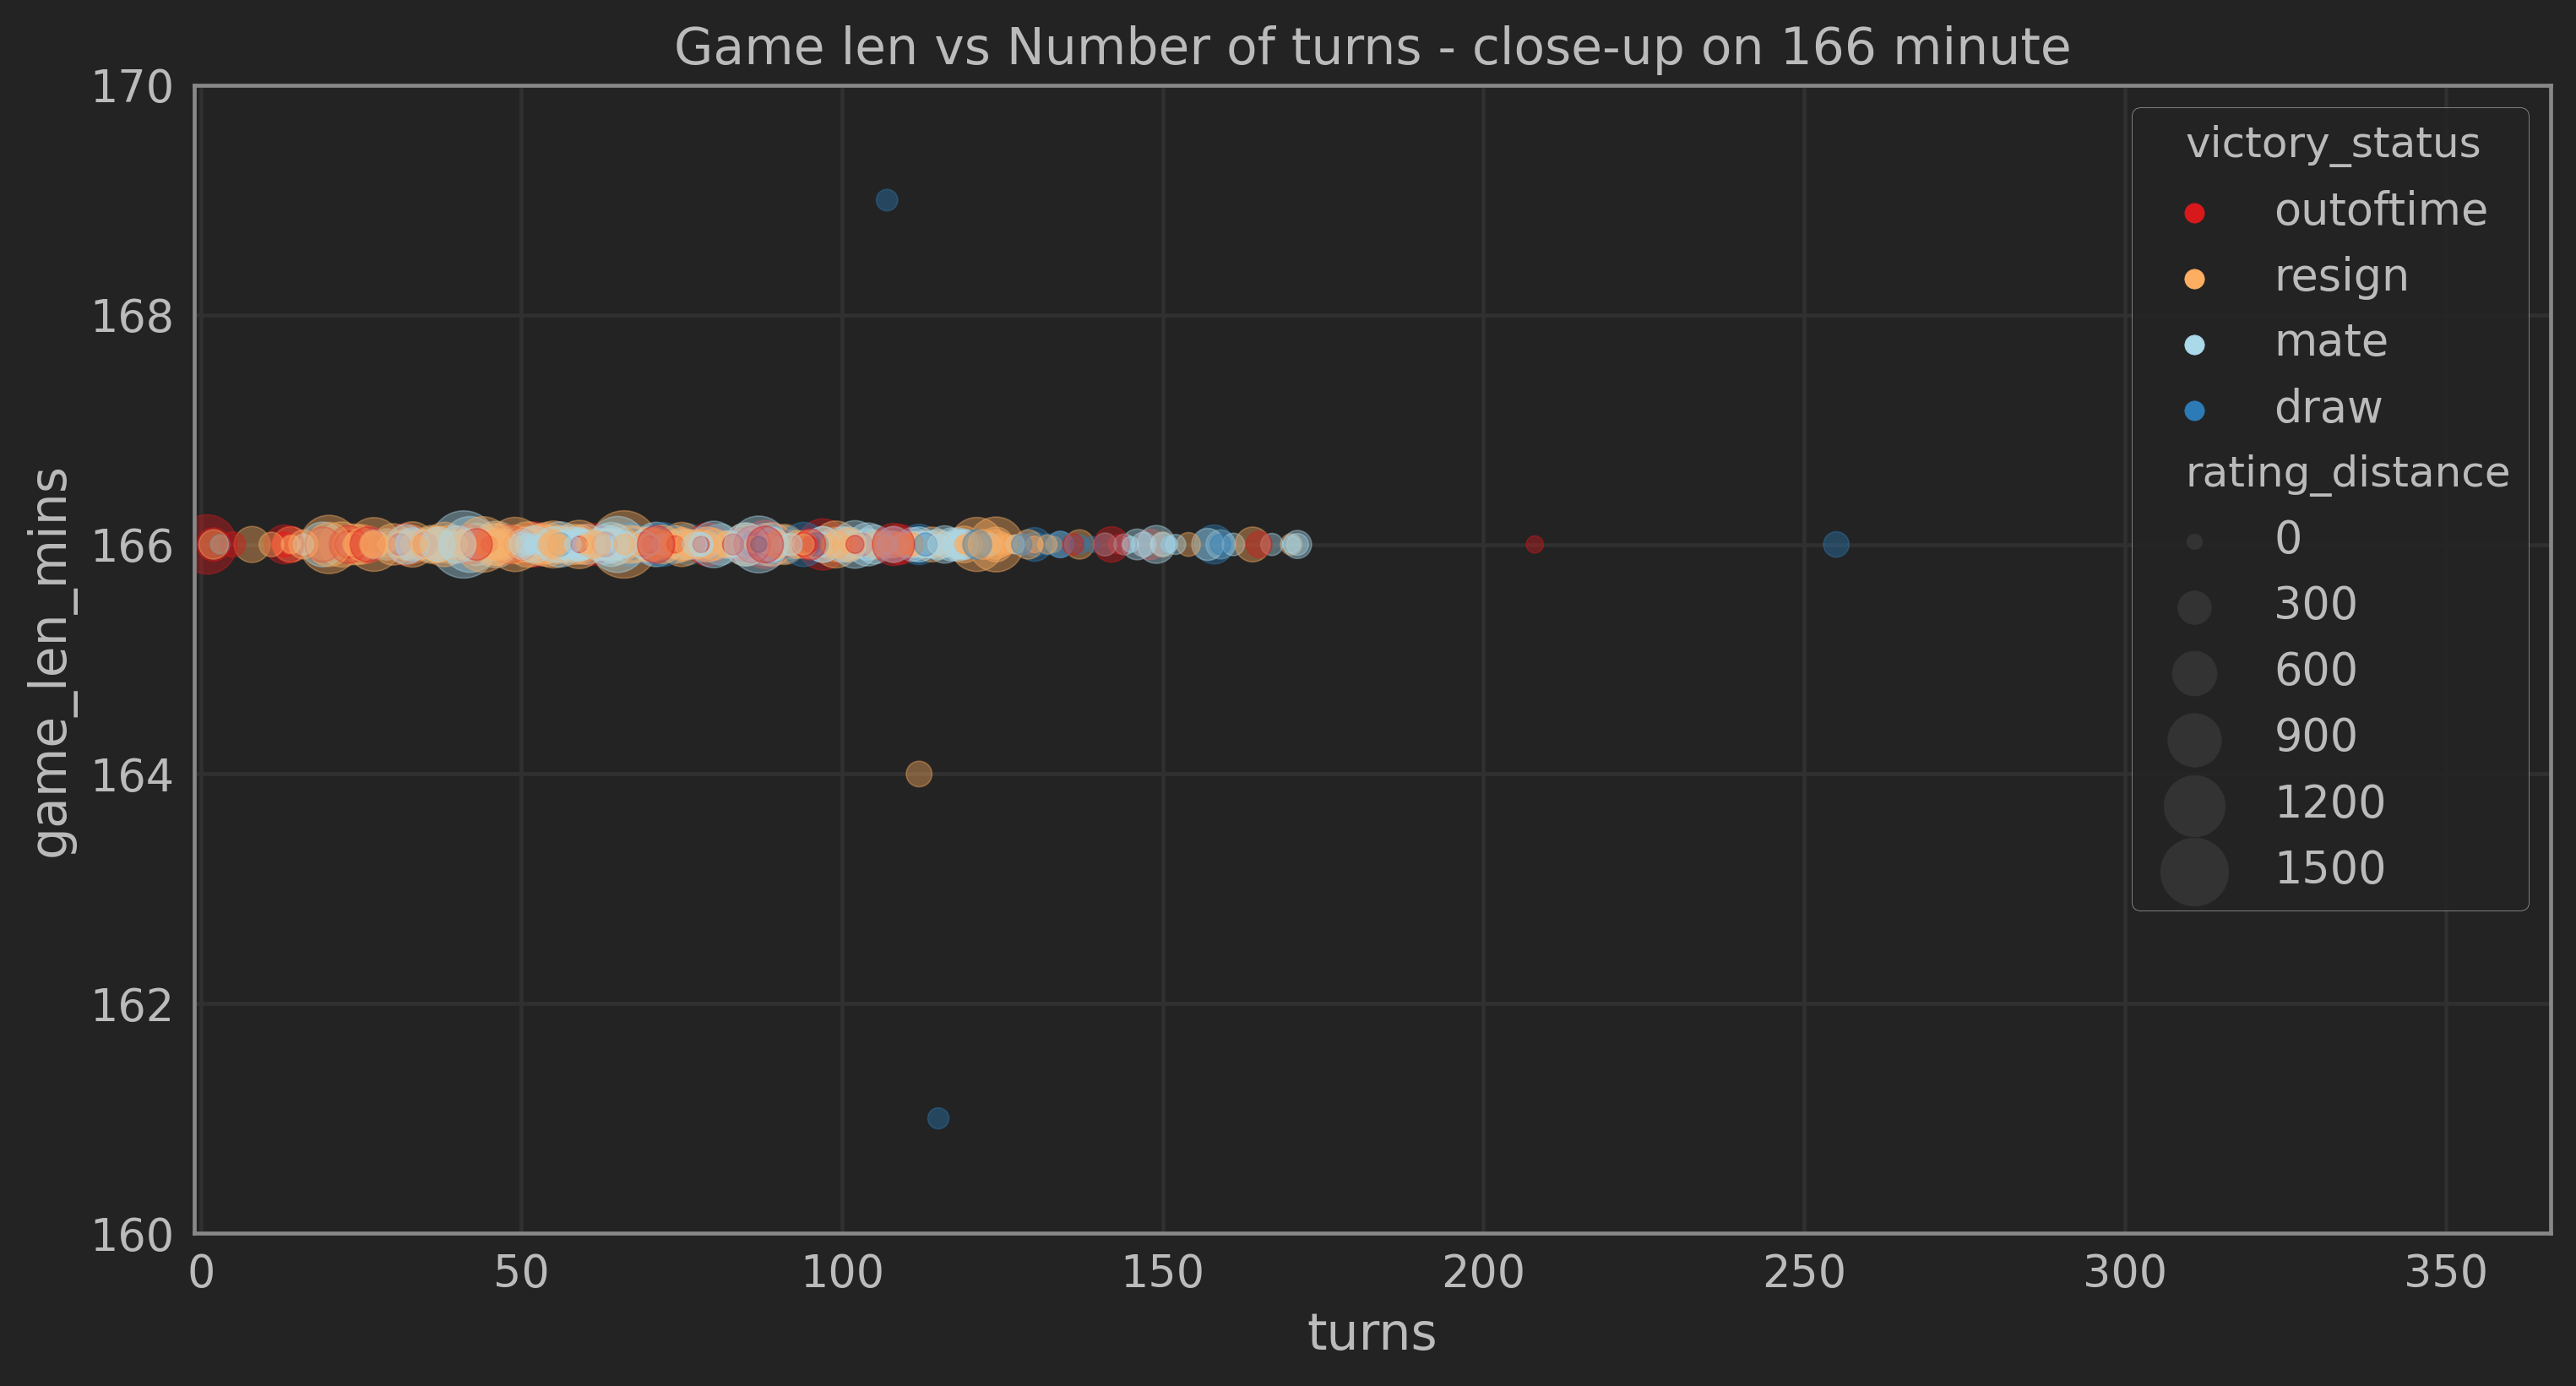

In [348]:
plt.figure(figsize=(12,6))

sns.scatterplot(data=GAMES,
                x='turns',
                y='game_len_mins',
                hue='victory_status',
                palette=qual_cmap,
                size='rating_distance',
                sizes=(20,400),
                edgecolor=None,
                s=10,
                alpha=0.4,
                legend=True)

plt.title('Game len vs Number of turns - close-up on 166 minute')
plt.xlim((-1))
plt.ylim((160,170))
plt.show()

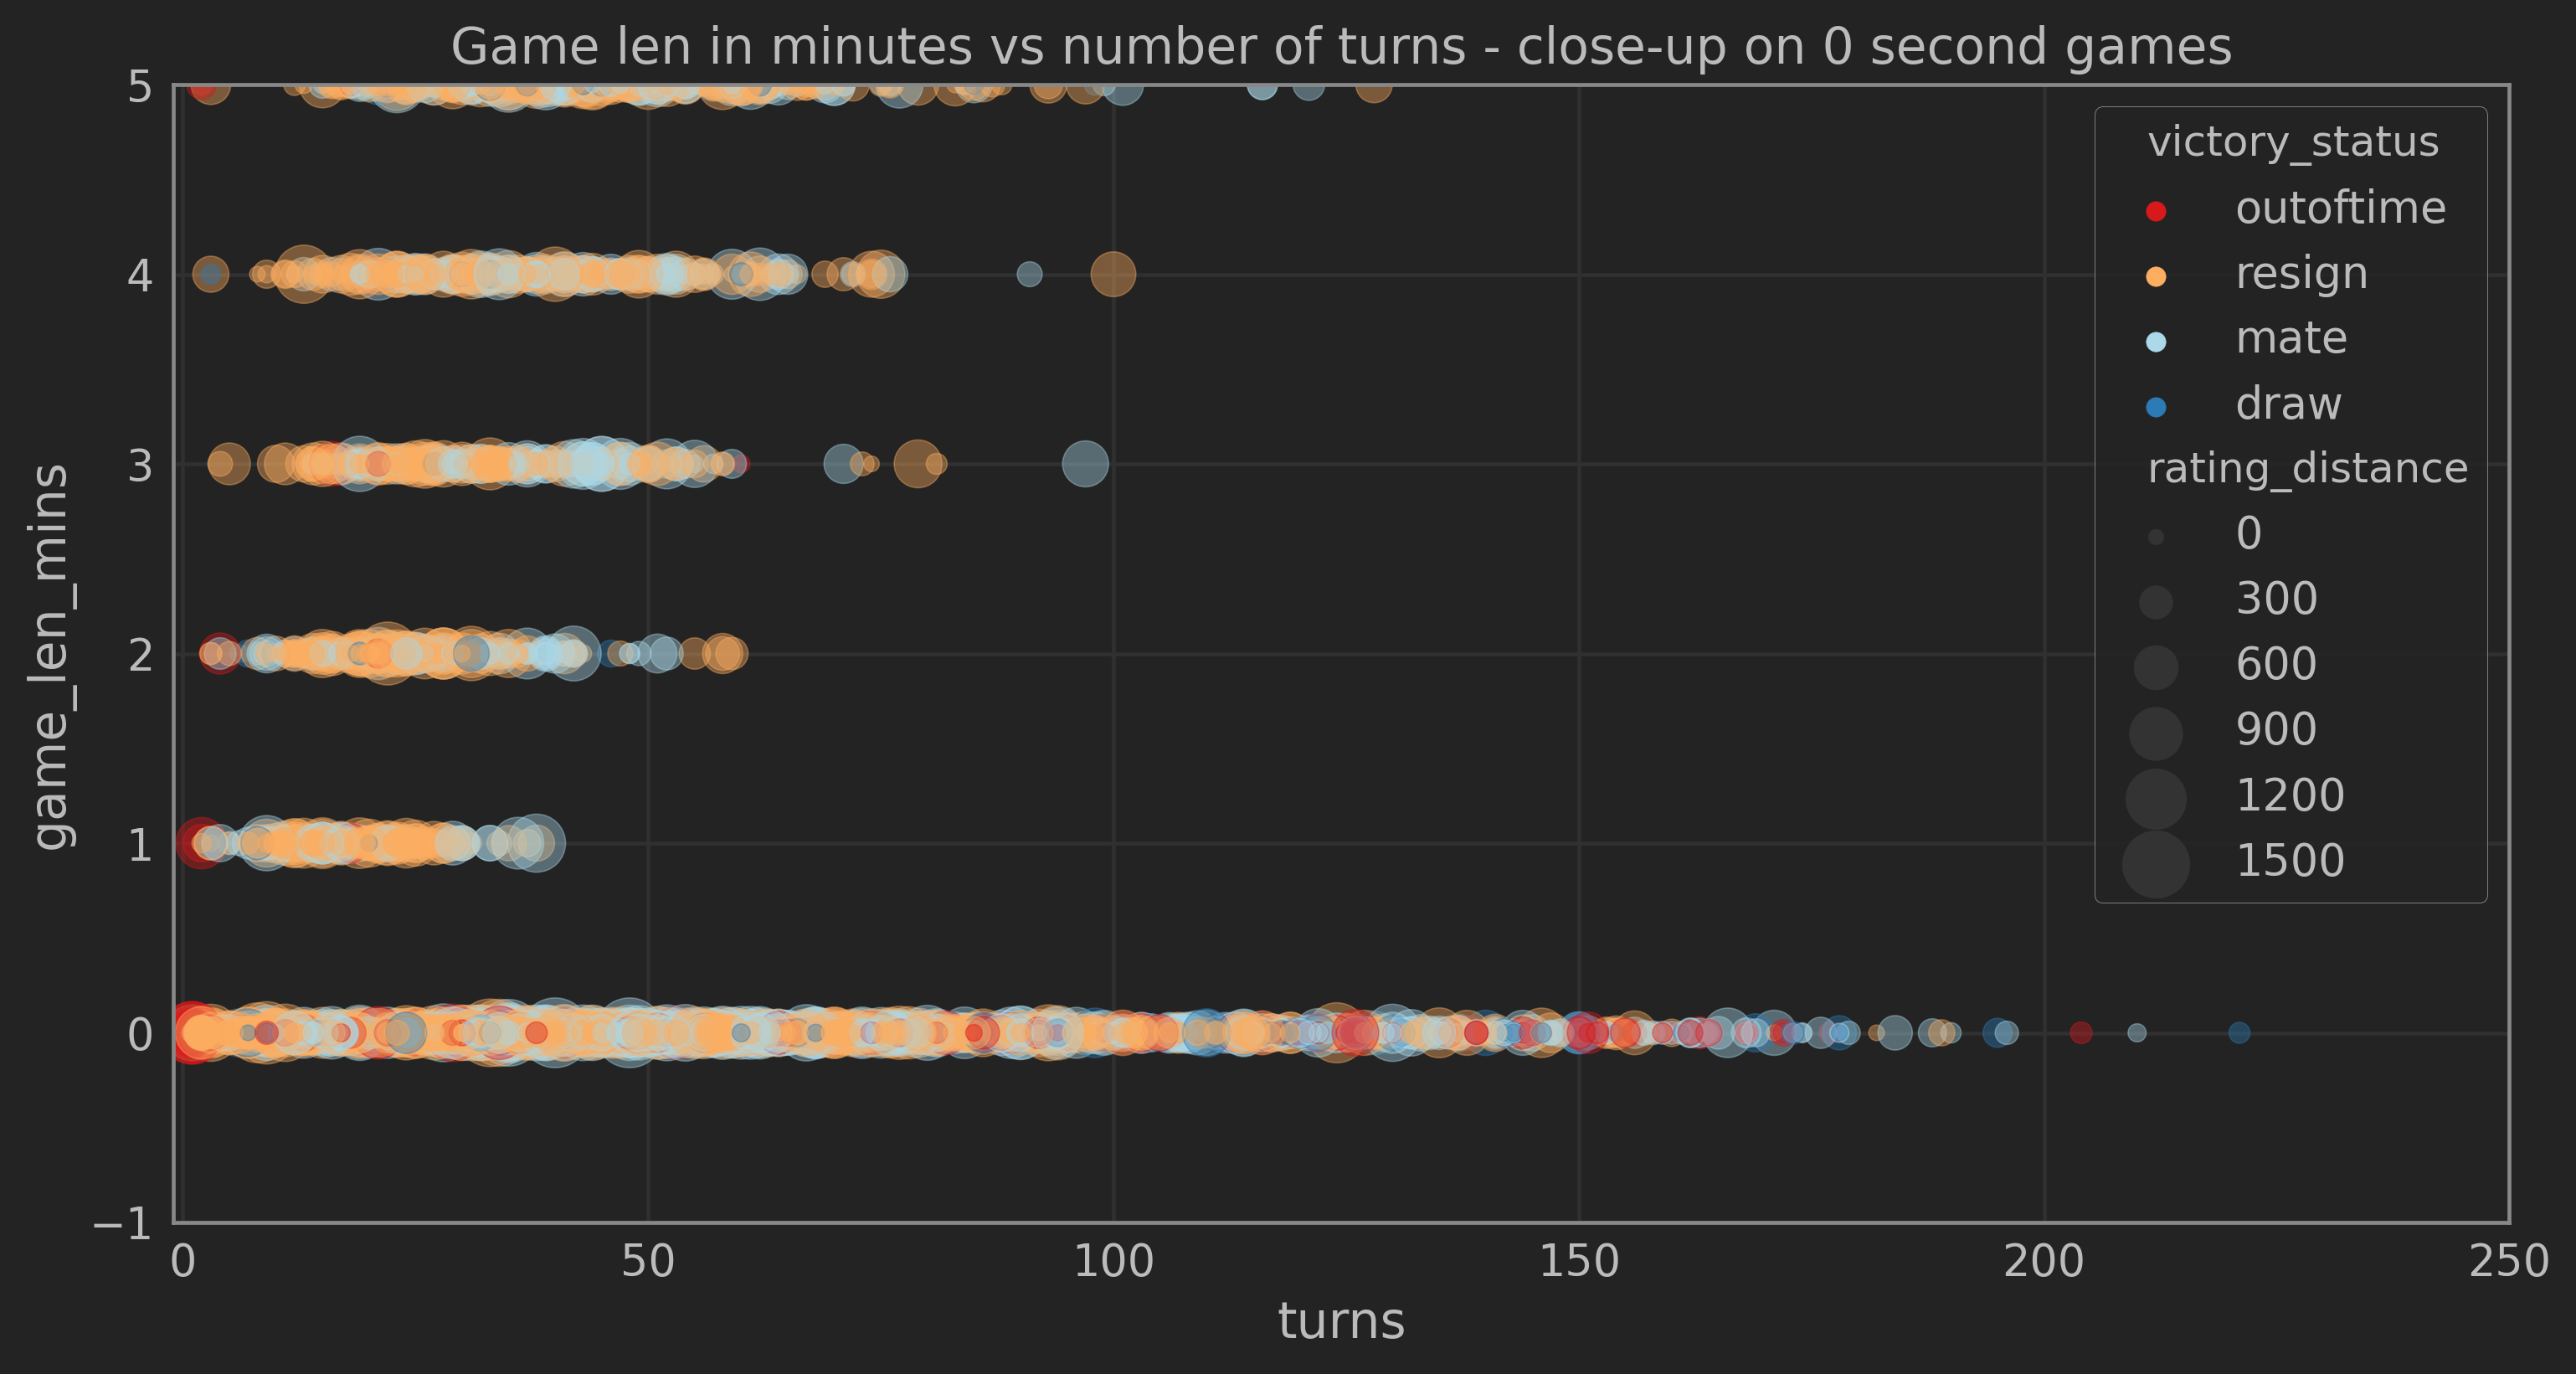

In [349]:
## Explore how points scatter according to length in minutes, number of turns and victory status
plt.figure(figsize=(12,6))

sns.scatterplot(data=GAMES[cols_vis],
                x='turns',
                y='game_len_mins',
                hue='victory_status',
                size='rating_distance',
                sizes=(20,400),
                palette=qual_cmap,
                edgecolor=None,
                s=15,
                alpha=0.4,
                legend=True)

plt.title('Game len in minutes vs number of turns - close-up on 0 second games')
plt.xlim((-1,250))
plt.ylim((-1,5))
plt.show()

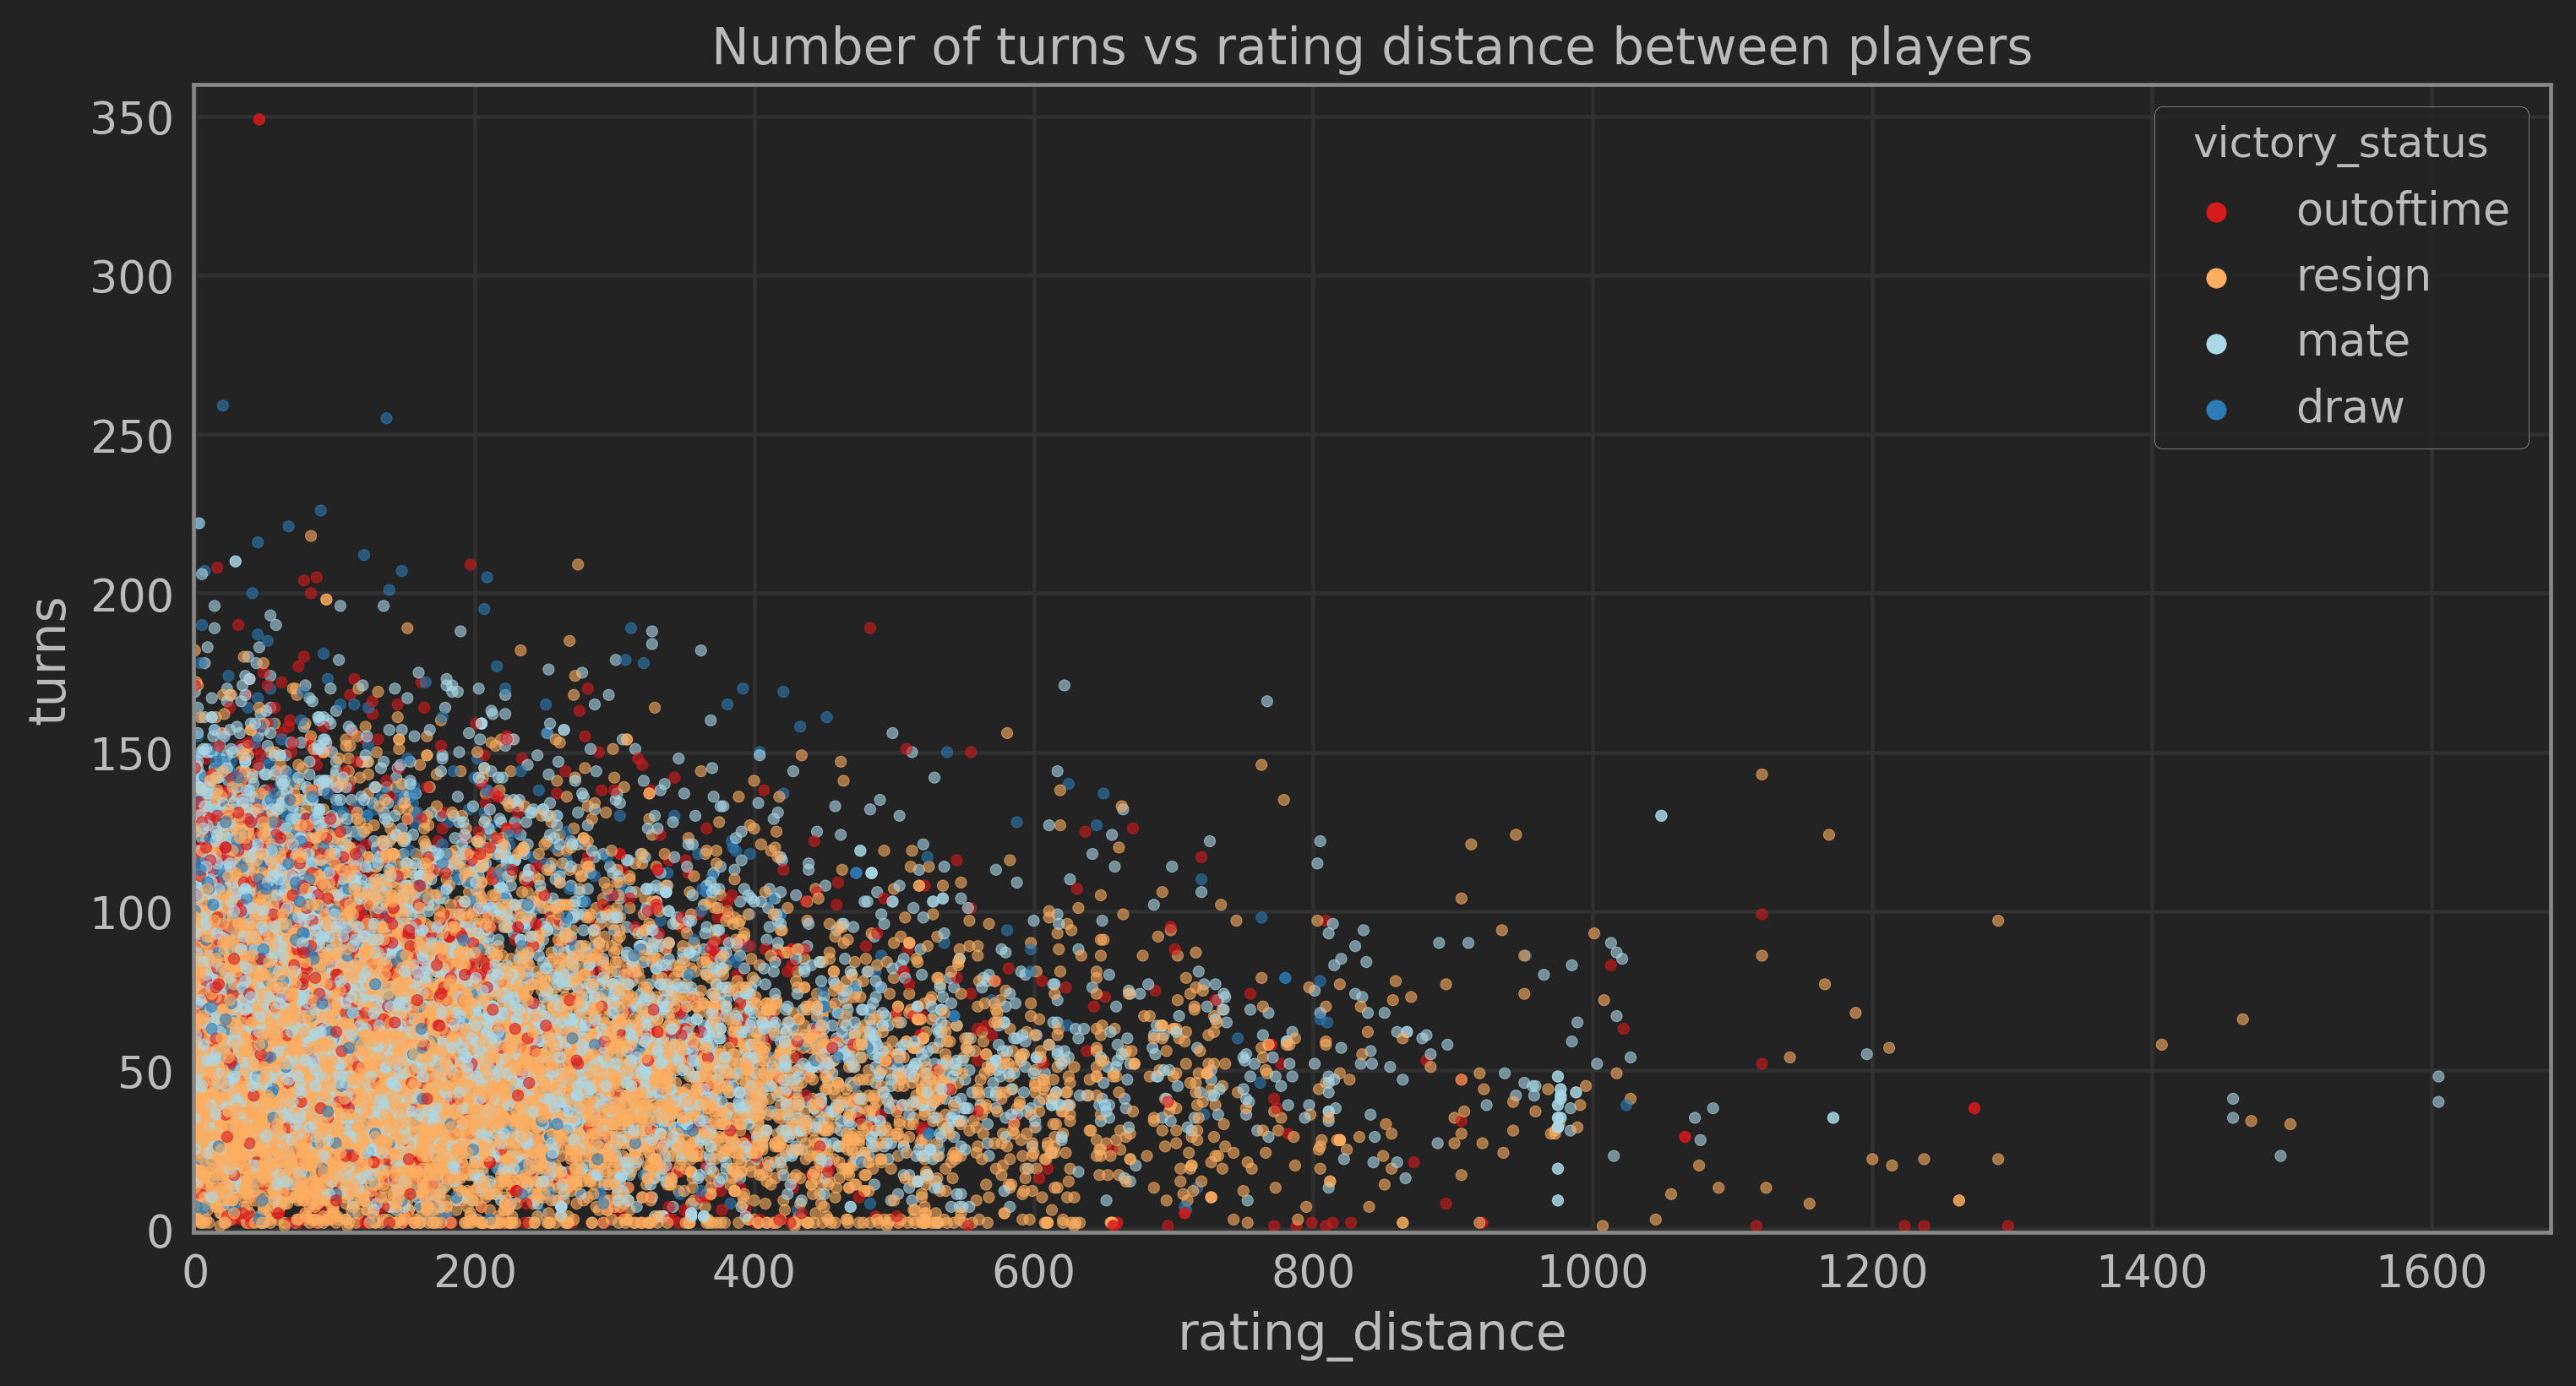

In [350]:
plt.figure(figsize=(12,6),dpi=300)

sns.scatterplot(data=GAMES,
                x='rating_distance',
                y='turns',
                hue='victory_status',
                palette=qual_cmap,
                edgecolor=None,
                s=10,
                alpha=0.6)

plt.title('Number of turns vs rating distance between players')
plt.xlim(-1)
plt.ylim(-1,360)
plt.show()

In [351]:
## Percentage of 0 seconds and 166 min games in the dataset
GAMES_0 = GAMES[(GAMES['game_len'] == 0) | (GAMES['game_len'] == 166)]
GAMES_0.shape[0] / GAMES.shape[0]

0.4261641240402832

## 3. Dataset vectorisation

---

### 3.1 Vectorized chess moves table

In [352]:
## Encode moves into separate variable
GAMES['moves_encoded'] = GAMES['moves'].apply(lambda x: encode_moves(x, 
                                                                     magnitude=10, 
                                                                     encoding='unicode'))

In [353]:
## Create Moves Table
MOVES = GAMES[['moves_encoded','id']]
MOVES.reset_index(inplace=True, drop=True)

MOVES.head()

moves_encoded        id
0  [5200, 5300, 5148, 5346, 62964000, 5454, 65448...  TZJHLljE
1  [5200, 416988, 5252, 5353, 5304, 5508, 6423600...  l1NXvwaE
2  [5252, 5353, 5100, 5400, 339966, 5346, 333300,...  mIICvQHh
3  [5200, 5300, 405756, 356796, 393822, 429624, 3...  kWKvrqYL
4  [5252, 5353, 405756, 5400, 5200, 416988, 5300,...  9tXo1AUZ

In [354]:
## Form a vector out of moves_encoded variable
MOVES_EXPLODED = MOVES.explode(column='moves_encoded')

In [355]:
## Construct a list of dataframes representing vectorised games
transposed_moves = move_vectorizer(MOVES_EXPLODED)

  0%|          | 0/20058 [00:00<?, ?it/s]

In [ ]:
## Concat all vectors into a single dataframe
MOVES_V = pd.concat(transposed_moves)

In [356]:
MOVES_V.fillna(0, inplace=True)

In [384]:
MOVES_V.index.rename('id',inplace=True)

In [385]:
MOVES_V.reset_index(drop=True, inplace=True)

In [386]:
MOVES_V.to_csv('./vec.csv')

### 3.1 Vectorized games meta-data

In [358]:
## Instantiate One Hot Encoder
ohe = OneHotEncoder(handle_unknown='error')

In [359]:
## Instantiate Count Vectorizer
cve = CountVectorizer()

In [360]:
## Set column transformer
column_trans = make_column_transformer((ohe,to_hot_encode),
                                       remainder='passthrough')

In [361]:
## Fit column transformer
column_trans.fit(GAMES[to_hot_encode])

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['opening_eco', 'increment_code',
                                  'victory_status'])])

In [362]:
## Produce one-hot-encoded array 
hot_array = column_trans.transform(GAMES[to_hot_encode]).toarray()

HOT_ENCODED = pd.DataFrame(hot_array, 
                          columns = column_trans.get_feature_names())

/home/nef/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [363]:
## Form Meta game table
META = GAMES[num_cols].merge(HOT_ENCODED,
                     left_index=True,
                     right_index=True)

In [364]:
## Inspect META
META.head()

winner_bin  rated_bin  game_len_mins  opening_ply  onehotencoder__x0_A00  \
0           0          0              0            5                    0.0   
1           1          1              0            4                    0.0   
2           0          1              0            3                    0.0   
3           0          1              0            3                    0.0   
4           0          1              0            5                    0.0   

   onehotencoder__x0_A01  onehotencoder__x0_A02  onehotencoder__x0_A03  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   onehotencoder__x0_A04  onehotencoder__x0_A05  ...  onehotencoder__x1_9+9  \
0                    0.0                    0.0  ...                    0.0   
1                    0.0                    0.0  ...                    0.0   
2                    0.0                    0.0  ...                    0.0   
3                    0.0                    0.0  ...                    0.0   
4                    0.0                    0.0  ...                    0.0   

   onehotencoder__x1_90+0  onehotencoder__x1_90+120  onehotencoder__x1_90+30  \
0                     0.0                       0.0                      0.0   
1                     0.0                       0.0                      0.0   
2                     0.0                       0.0                      0.0   
3                     0.0                       0.0                      0.0   
4                     0.0                       0.0                      0.0   

   onehotencoder__x1_90+5  onehotencoder__x1_90+8  onehotencoder__x2_draw  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   onehotencoder__x2_mate  onehotencoder__x2_outoftime  \
0                     0.0                          1.0   
1                     0.0                          0.0   
2                     1.0                          0.0   
3                     1.0                          0.0   
4                     1.0                          0.0   

   onehotencoder__x2_resign  
0                       0.0  
1                       1.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 773 columns]

## 4. Data exploration with UMAP

---

**SECTIONS:**

[1. Staging](#1.-Staging) \
----[1.1 Project parametrisation](#1.1-Project-parametrisation) \
----[1.2 Functions](#1.2-Functions)

[2. Data preprocessing & initial dataset exploration](#2.-Data-preprocessing-&-initial-dataset-exploration) 

[3. Dataset vectorisation](#3.-Dataset-vectorisation)

[4. Data exploration with UMAP](#4.-Data-exploration-with-UMAP)

Instatiate & train the model:

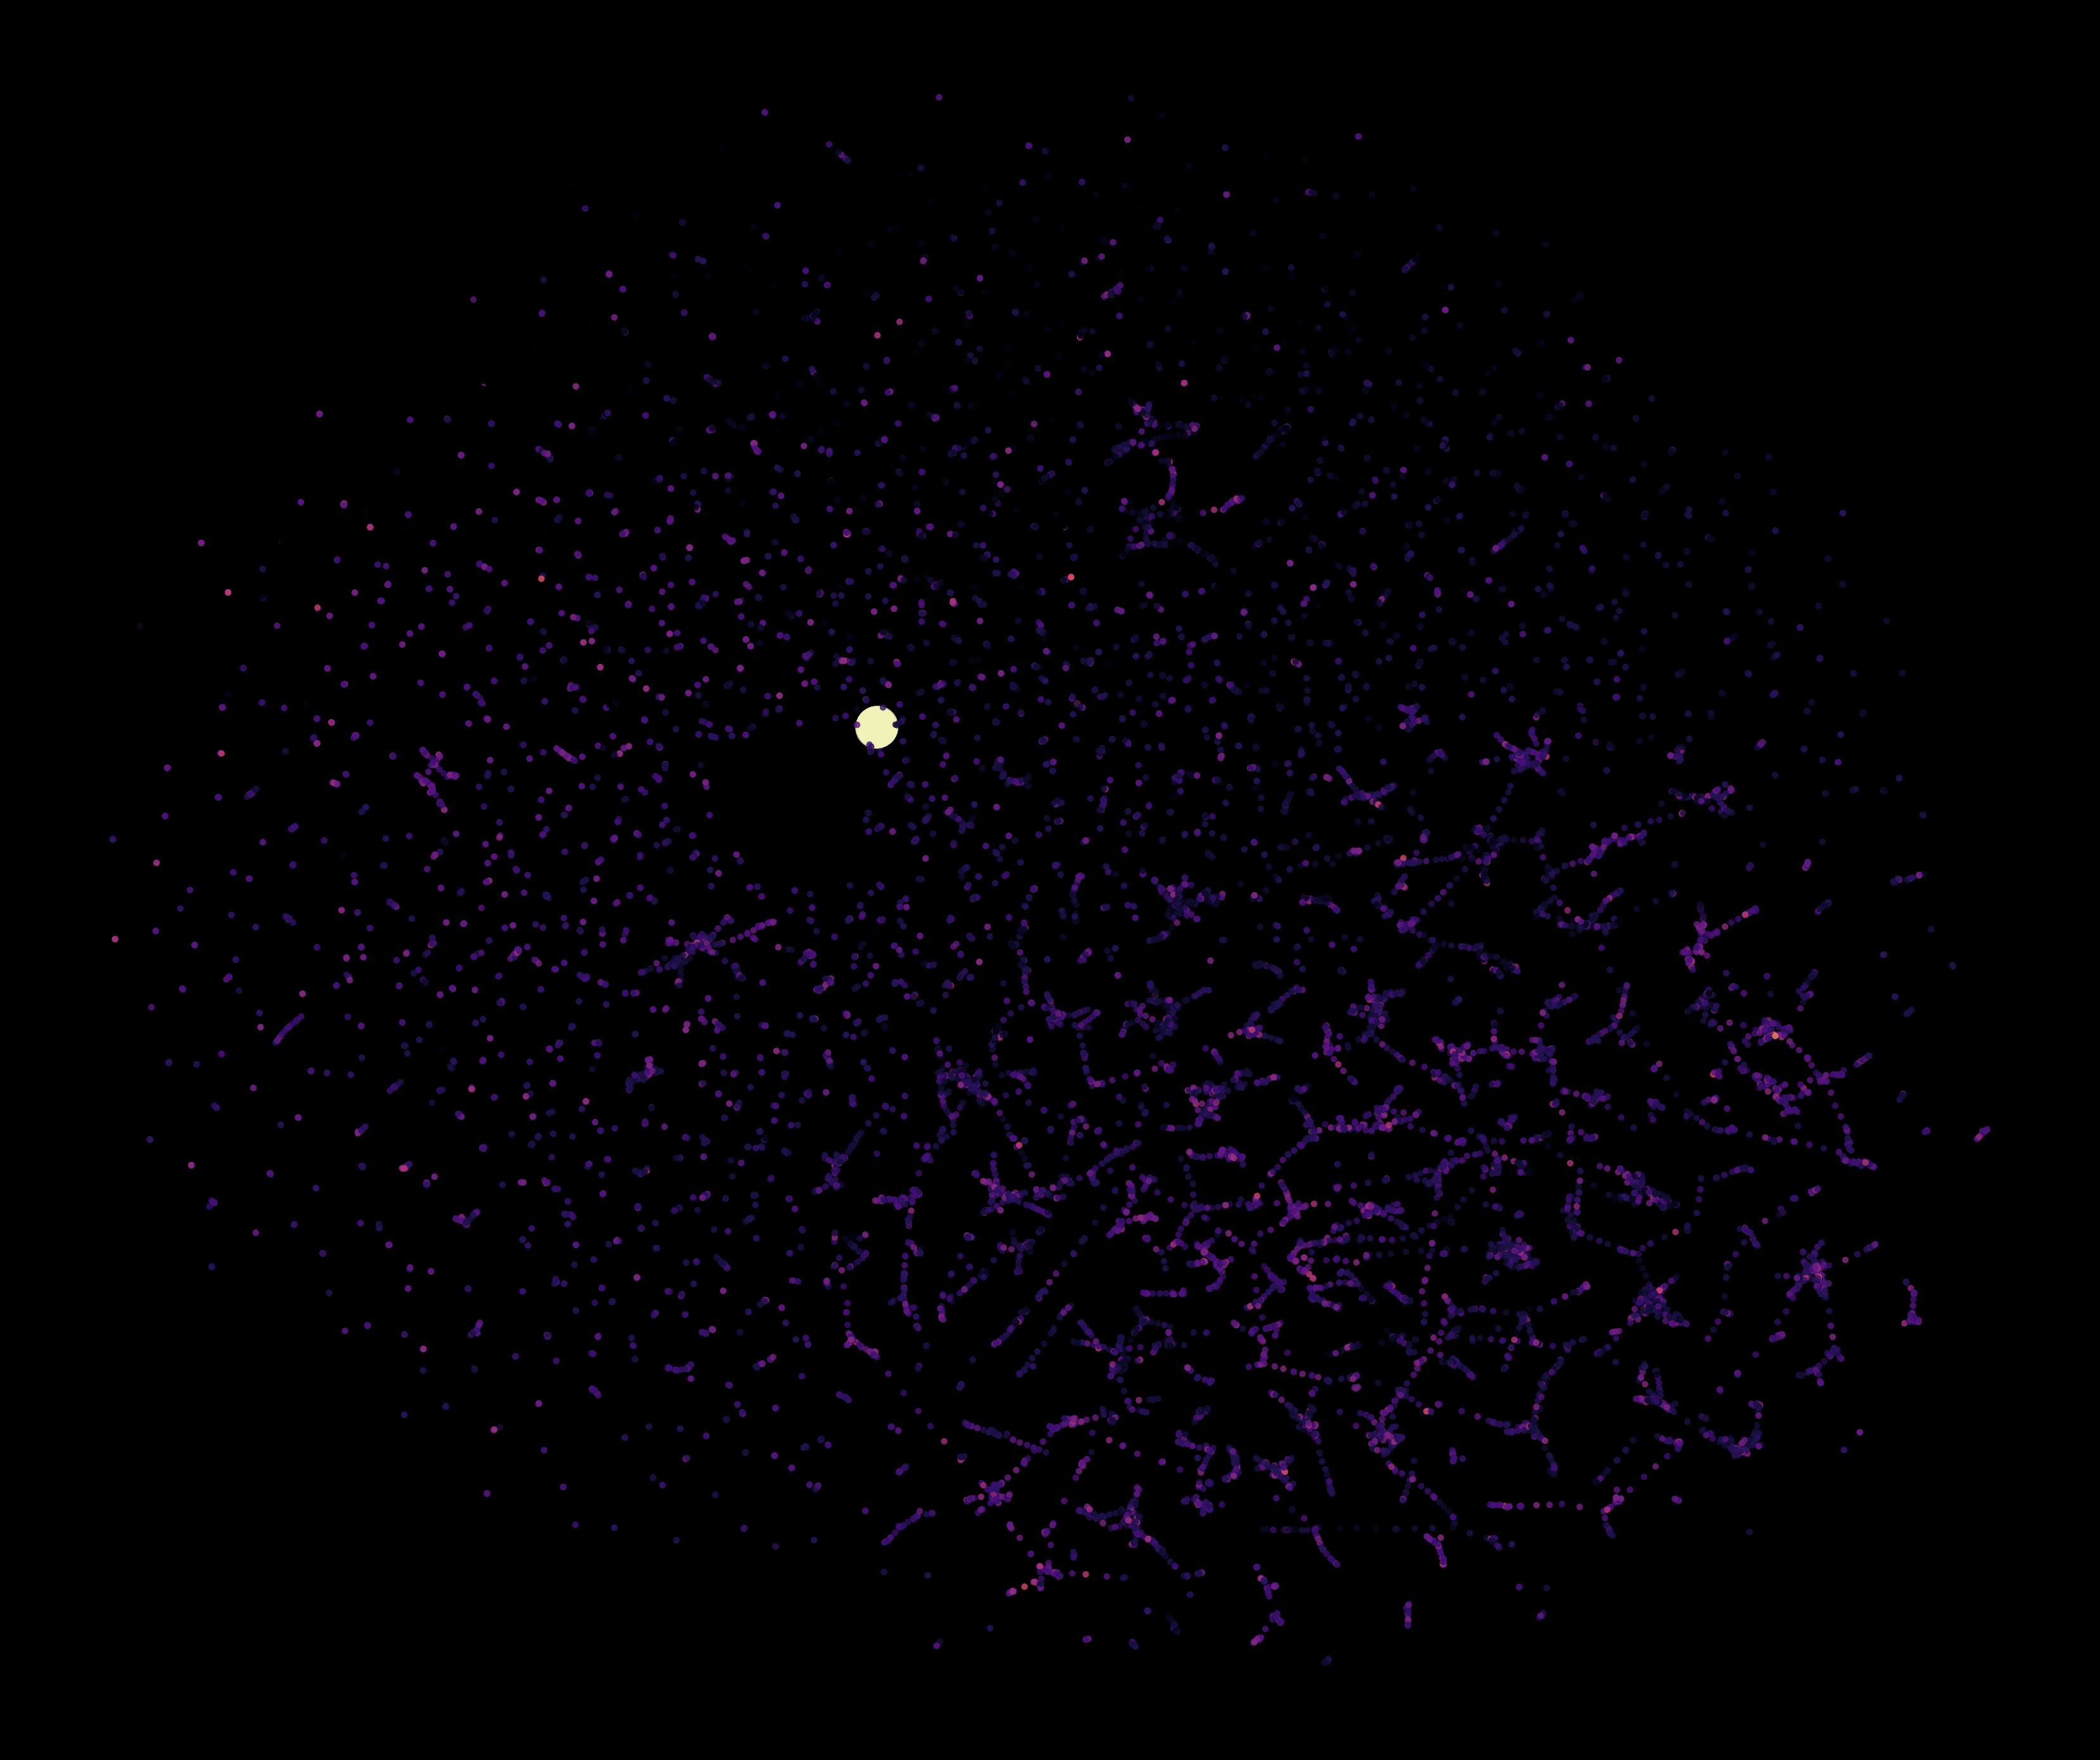

In [454]:
## data
input_vector = MOVES_V
cmap_var = GAMES['turns']

## UMAP params
distance_metric = 'cosine'
nn = 2
min_distance = 0.1

## Plot params
alpha = 0.8
marker_shape = 'o'
marker_size = 2
color_map = 'magma'
dpi = 300
title = 'VECTORISED MOVES - UNICODE CONVERSION'

## Execution
# EMBEDDING_DF = umap_transformer(input_vector, distance_metric, nn, min_distance)
plot_umap(EMBEDDING_DF, marker_shape, marker_size , cmap_var, color_map, alpha, distance_metric, nn, min_distance, title, dpi)